# Netflix Data Exploration Business Case

## Problem Statement

### Netflix is one of the most popular media and video streaming platforms. They have over 8000 movies or tv shows available on their platform, as of mid-2021, they have over 200M Subscribers globally.The particular business case focuses on the Netflix show data and provides insightful information on 8807 shows. Analyzing the data and generating insights helps Netflix decide which type of shows/movies to produce and how to grow the business.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install wordcloud
from wordcloud import WordCloud

In [2]:
df=pd.read_csv('netflix.csv',index_col=0)
df.shape

(8807, 11)

## 8807 rows and 11 columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8807 entries, s1 to s8807
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          8807 non-null   object
 1   title         8807 non-null   object
 2   director      6173 non-null   object
 3   cast          7982 non-null   object
 4   country       7976 non-null   object
 5   date_added    8797 non-null   object
 6   release_year  8807 non-null   int64 
 7   rating        8803 non-null   object
 8   duration      8804 non-null   object
 9   listed_in     8807 non-null   object
 10  description   8807 non-null   object
dtypes: int64(1), object(10)
memory usage: 825.7+ KB


# PREPROCESSING

## Unnesting the columns

In [4]:
df['director']=df['director'].str.strip()
df['director'] = df['director'].str.split(',')
df = df.explode('director')
df['director']=df['director'].str.strip()

df['cast']=df['cast'].str.strip()
df['cast'] = df['cast'].str.split(',')
df = df.explode('cast')
df['cast']=df['cast'].str.strip()

df['country']=df['country'].str.strip()
df['country'] = df['country'].str.split(',')
df = df.explode('country')
df['country']=df['country'].str.strip()

df['listed_in']=df['listed_in'].str.strip()
df['listed_in'] = df['listed_in'].str.split(',')
df = df.explode('listed_in')
df['listed_in']=df['listed_in'].str.strip()

df=df.drop_duplicates(subset=['title','country','director','cast','listed_in'])
df.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
s2,TV Show,Blood & Water,NaN,Ama Qamata,South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,International TV Shows,"After crossing paths at a party, a Cape Town t..."
s2,TV Show,Blood & Water,NaN,Ama Qamata,South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,TV Dramas,"After crossing paths at a party, a Cape Town t..."
s2,TV Show,Blood & Water,NaN,Ama Qamata,South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,TV Mysteries,"After crossing paths at a party, a Cape Town t..."
s2,TV Show,Blood & Water,NaN,Khosi Ngema,South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,International TV Shows,"After crossing paths at a party, a Cape Town t..."


In [5]:
df.isna().sum()

type                0
title               0
director        50643
cast             2149
country         11897
date_added        158
release_year        0
rating             67
duration            3
listed_in           0
description         0
dtype: int64

## Adding week_added and month_added columns to use in Part 3

In [6]:
df['date_added']=df['date_added'].str.strip()
df['date_added']=pd.to_datetime(df['date_added'],format="%B %d, %Y")
df['week_added']=df['date_added'].dt.isocalendar().week
df['month_added']=df['date_added'].dt.month

## Adding datediff_day column to use in Part 6

### Assuming release date as 'release_year-07-01' for simplicity

In [7]:
df['datediff_day'] = (df['date_added'] - pd.to_datetime(df['release_year'].astype(str) + '-07-01')).dt.days

## Filling Missing Values

### director:'Unknown Director'
### cast :'Unknown Cast'
### country :'International'
### rating :'unrated'
### For duration and date columns used reference column groupby mode method

In [8]:
df.fillna({'director':'Unknown Director','cast':'Unknown Cast','country':'International','rating':'unrated'},inplace=True)
mode_duration = df.groupby('type')['duration'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NaT).reset_index()
mode_dict = dict(zip(mode_duration['type'], mode_duration['duration']))
df['duration'] = df['duration'].fillna(df['type'].map(mode_dict))

## Date Columns

In [9]:
mode_values = df.groupby('country').agg({
    'date_added': lambda x: x.dt.date.mode().iloc[0] if not x.dt.date.mode().empty else pd.NaT,
    'week_added': lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NaT,
    'month_added': lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NaT,
    'datediff_day': lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NaT
}).reset_index()

date_added_dict = dict(zip(mode_values['country'], mode_values['date_added']))
week_added_dict = dict(zip(mode_values['country'], mode_values['week_added']))
month_added_dict = dict(zip(mode_values['country'], mode_values['month_added']))
datediff_day_dict = dict(zip(mode_values['country'], mode_values['datediff_day']))

df['date_added'] = df['date_added'].fillna(df['country'].map(date_added_dict))
df['week_added'] = df['week_added'].fillna(df['country'].map(week_added_dict))
df['month_added'] = df['month_added'].fillna(df['country'].map(month_added_dict))
df['datediff_day'] = df['datediff_day'].fillna(df['country'].map(datediff_day_dict))
df.isna().sum()

type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
week_added      0
month_added     0
datediff_day    0
dtype: int64

## All null values carefully replaced

In [10]:
df.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,week_added,month_added,datediff_day
show_id,,,,,,,,,,,,,,
s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown Cast,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",38,9.0,451.0
s2,TV Show,Blood & Water,Unknown Director,Ama Qamata,South Africa,2021-09-24,2021,TV-MA,2 Seasons,International TV Shows,"After crossing paths at a party, a Cape Town t...",38,9.0,85.0
s2,TV Show,Blood & Water,Unknown Director,Ama Qamata,South Africa,2021-09-24,2021,TV-MA,2 Seasons,TV Dramas,"After crossing paths at a party, a Cape Town t...",38,9.0,85.0
s2,TV Show,Blood & Water,Unknown Director,Ama Qamata,South Africa,2021-09-24,2021,TV-MA,2 Seasons,TV Mysteries,"After crossing paths at a party, a Cape Town t...",38,9.0,85.0
s2,TV Show,Blood & Water,Unknown Director,Khosi Ngema,South Africa,2021-09-24,2021,TV-MA,2 Seasons,International TV Shows,"After crossing paths at a party, a Cape Town t...",38,9.0,85.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202010 entries, s1 to s8807
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   type          202010 non-null  object        
 1   title         202010 non-null  object        
 2   director      202010 non-null  object        
 3   cast          202010 non-null  object        
 4   country       202010 non-null  object        
 5   date_added    202010 non-null  datetime64[ns]
 6   release_year  202010 non-null  int64         
 7   rating        202010 non-null  object        
 8   duration      202010 non-null  object        
 9   listed_in     202010 non-null  object        
 10  description   202010 non-null  object        
 11  week_added    202010 non-null  UInt32        
 12  month_added   202010 non-null  float64       
 13  datediff_day  202010 non-null  float64       
dtypes: UInt32(1), datetime64[ns](1), float64(2), int64(1), object(9)
memory u

## There are 202010 rows and 14 columns. 
## Index:'show_id'
## String categorical columns:'type','title','director','cast','country','duration','listed_in','description','rating'(later converted to numerical)
## Datetime column:'date_added'
## Numerical int and float columns:'release_year','week_added','month_added','datediff_day'

In [12]:
df.describe()

,date_added,release_year,week_added,month_added,datediff_day
count,202010,202010.000000,202010.0,202010.000000,202010.000000
mean,2019-06-19 19:50:28.305529088,2013.448334,26.685877,6.634186,2015.155784
min,2008-01-01 00:00:00,1925.000000,1.0,1.000000,-1188.000000
25%,2018-06-26 00:00:00,2012.000000,14.0,4.000000,123.000000
50%,2019-09-06 00:00:00,2016.000000,27.0,7.000000,609.000000
75%,2020-09-10 00:00:00,2019.000000,39.0,10.000000,2588.000000
max,2021-09-25 00:00:00,2021.000000,53.0,12.000000,34150.000000
std,NaN,9.013446,15.059867,3.443575,3310.996342


## Basic Metrics Analysis:

**Dataset Overview:**
    - The dataset contains information on 8,807 shows available on Netflix.
    - Key attributes include 'show_id,' 'type' (Movie or TV Show), 'title,' 'director,' 
    'cast,' 'country,' 'date_added,' 'release_year,' 'duration,' 'listed_in,' and 'rating.'

**Temporal Scope:**
    - The dataset spans multiple years, providing a temporal perspective on the content available on Netflix.

**Geographical Reach:**
    - Shows are distributed across various countries, allowing for a region-wise analysis.

**Content Types:**
    - The dataset categorizes shows into two main types: Movies and TV Shows.

**Data Quality:**
    - Initial analysis reveals missing values, especially in attributes like 'director,' 'cast,' 'country,' and 'rating.'
    - Strategies such as filling missing values with defaults ('Unknown Director,' 'Unknown Cast,' 'International,' 'unrated') have been employed.
    - For date columns and duration reference column groupby mode method applied to replace missing values.

**Duration Information:**
    - Duration information is available for both Movies (in minutes) and TV Shows (in seasons).

**Timing of inclusion:**
    - The dataset includes information on when shows were added to Netflix ('date_added').
    - Additional columns ('week_added,' 'month_added') have been created for temporal analysis.

**Datediff Calculation:**
    - A 'datediff_day' column has been introduced, representing the difference between 'date_added' and a presumed release date ('release_year-07-01').

**Preliminary Analysis:**
    - Preliminary univariate analysis(and bivariate for some attributes) has been conducted on key attributes such as 'type,' 'director,' 'cast,' 'country,' 'rating,' 'listed_in,' and 'duration.'

## 1. Preliminary Analysis

In [13]:
#a.type
type_group=df.groupby('type')['title'].nunique().reset_index()
type_group.columns=['type','uniquecount']
type_group.head()

,type,uniquecount
0,Movie,6131
1,TV Show,2676


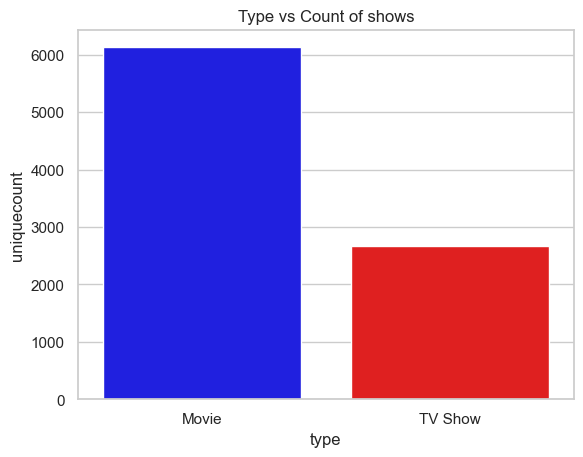

In [14]:
sns.set(style="whitegrid")
palette = {'Movie': 'blue', 'TV Show': 'red'}
ax=sns.barplot(data=type_group, x='type', y='uniquecount', hue='type', palette=palette)
plt.title('Type vs Count of shows')
plt.show()

## Insights: 6131 movies and 2676 TV Shows are added.More movies have been added.

In [15]:
#b.director
director_group=df.groupby('director')['title'].nunique().reset_index().sort_values('title',ascending=False)
director_group.columns=['director','uniquecount']
director_group=director_group.iloc[:11]
director_group=director_group[director_group['director']!='Unknown Director'].reset_index()
director_group.drop(columns='index',inplace=True)
director_group.head()

,director,uniquecount
0,Rajiv Chilaka,22
1,Jan Suter,21
2,Raúl Campos,19
3,Marcus Raboy,16
4,Suhas Kadav,16


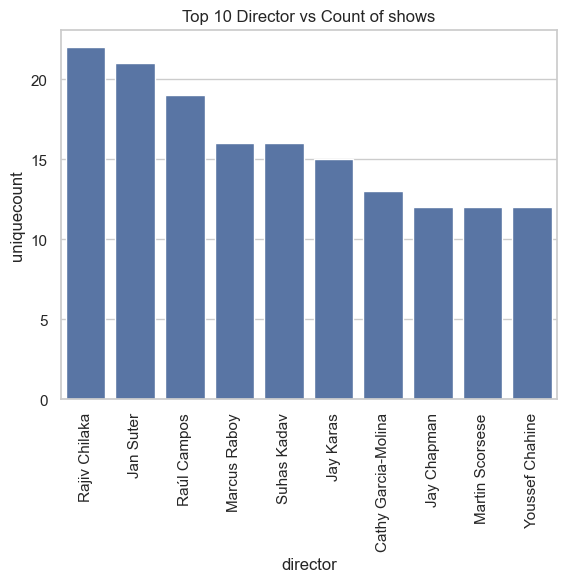

In [16]:
sns.set(style="whitegrid")
sns.barplot(data=director_group,x='director',y='uniquecount')
plt.xticks(rotation=90)
plt.title('Top 10 Director vs Count of shows')
plt.show()

In [17]:
#c.cast
cast_group=df.groupby('cast')['title'].nunique().reset_index().sort_values('title',ascending=False)
cast_group.columns=['cast','uniquecount']
cast_group=cast_group.iloc[:11]
cast_group=cast_group[cast_group['cast']!='Unknown Cast'].reset_index()
cast_group.drop(columns='index',inplace=True)
cast_group.head()

,cast,uniquecount
0,Anupam Kher,43
1,Shah Rukh Khan,35
2,Julie Tejwani,33
3,Naseeruddin Shah,32
4,Takahiro Sakurai,32


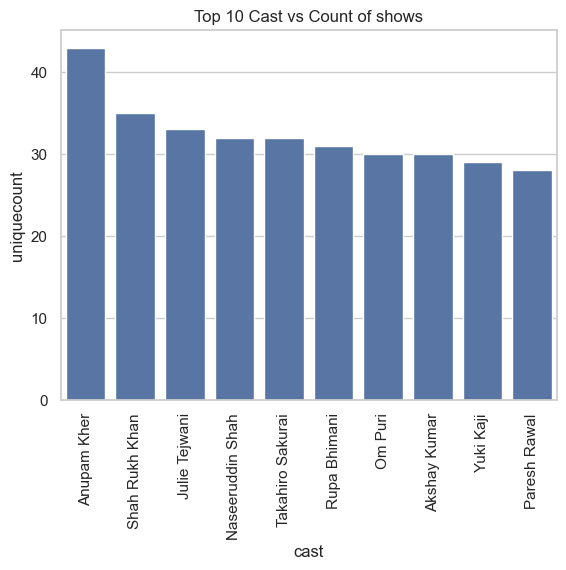

In [18]:
sns.set(style="whitegrid")
sns.barplot(data=cast_group,x='cast',y='uniquecount')
plt.xticks(rotation=90)
plt.title('Top 10 Cast vs Count of shows')
plt.show()

In [19]:
#d.country
country_group=df.groupby('country')['title'].nunique().reset_index().sort_values('title',ascending=False)
country_group.columns=['country','uniquecount']
country_group=country_group.iloc[:10].reset_index()
country_group.drop(columns='index',inplace=True)
country_group.head()

,country,uniquecount
0,United States,3690
1,India,1046
2,International,831
3,United Kingdom,806
4,Canada,445


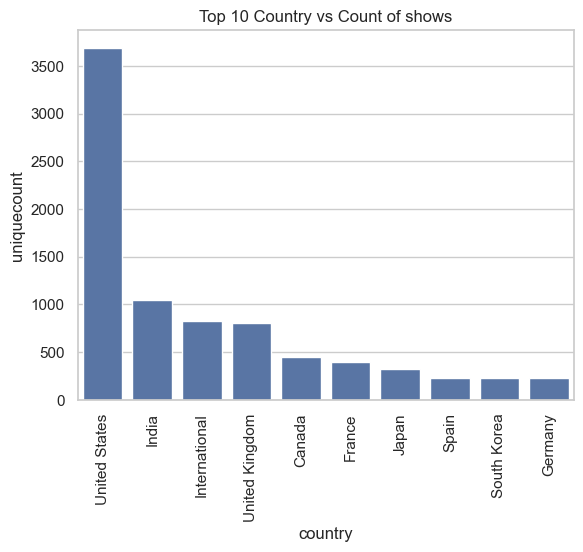

In [20]:
sns.set(style="whitegrid")
sns.barplot(data=country_group,x='country',y='uniquecount')
plt.xticks(rotation=90)
plt.title('Top 10 Country vs Count of shows')
plt.show()

## Insights: USA,India and UK are the most common countries.

In [21]:
#e.rating
rating_group=df.groupby('rating')['title'].nunique().reset_index().sort_values('title',ascending=False)
rating_group.columns=['rating','uniquecount']
rating_group=pd.merge(rating_group, df[['rating', 'type']], on='rating', how='left')
rating_group=rating_group.drop_duplicates(subset='rating').reset_index().drop(columns=['index'])
rating_group.head()

,rating,uniquecount,type
0,TV-MA,3207,TV Show
1,TV-14,2160,TV Show
2,TV-PG,863,Movie
3,R,799,Movie
4,PG-13,490,Movie


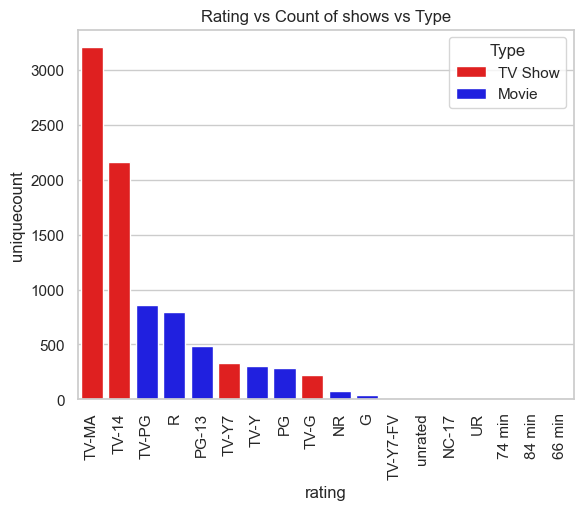

In [22]:
sns.set(style="whitegrid")
sns.barplot(data=rating_group,x='rating',y='uniquecount',hue='type',palette={'Movie': 'blue', 'TV Show': 'red'})
plt.xticks(rotation=90)
plt.title('Rating vs Count of shows vs Type')
plt.legend(title='Type')
plt.show()

In [23]:
#f.listed_in
listed_in_group=df.groupby('listed_in')['title'].nunique().reset_index().sort_values('title',ascending=False)
listed_in_group.columns=['listed_in','uniquecount']
listed_in_group=pd.merge(listed_in_group, df[['listed_in', 'type']], on='listed_in', how='left')
listed_in_group=listed_in_group.drop_duplicates(subset=['listed_in','type']).reset_index().drop(columns=['index'])
listed_in_group=listed_in_group.iloc[:10]
listed_in_group.head()

,listed_in,uniquecount,type
0,International Movies,2752,Movie
1,Dramas,2427,Movie
2,Comedies,1674,Movie
3,International TV Shows,1351,TV Show
4,Documentaries,869,Movie


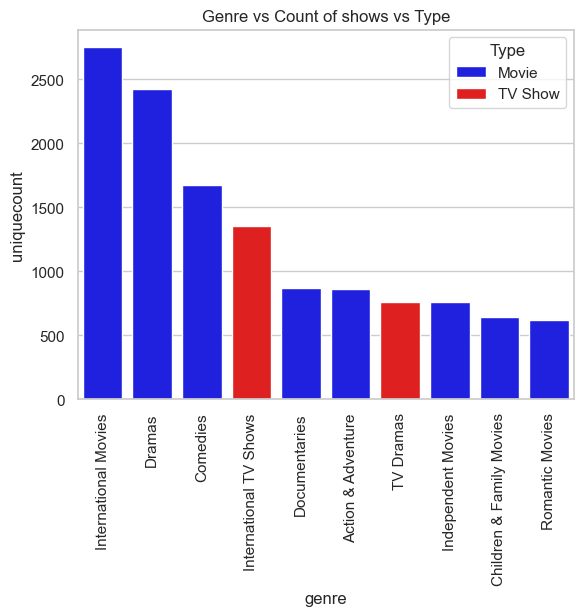

In [24]:
sns.set(style="whitegrid")
sns.barplot(data=listed_in_group,x='listed_in',y='uniquecount',hue='type',palette={'Movie': 'blue', 'TV Show': 'red'})
plt.xticks(rotation=90)
plt.title('Genre vs Count of shows vs Type')
plt.xlabel('genre')
plt.legend(title='Type')
plt.show()

## Insights: International Movies,Dramas,and Comedies are the most common Movie genres whreas for TV Shows it is International TV Shows and TV Dramas.In Part 5 the result for Movies is confirmed again.

In [25]:
#g. duration
movie=df[df['type']=='Movie']
tv_show=df[df['type']=='TV Show']

movieduration=movie.groupby('duration')['title'].nunique().reset_index().sort_values('title',ascending=False)
movieduration.columns=['duration','uniquecount']
movieduration.reset_index(inplace=True)
movieduration.drop(columns=['index'],inplace=True)
movieduration.head()

,duration,uniquecount
0,90 min,152
1,94 min,149
2,93 min,146
3,97 min,146
4,91 min,144


## Extracting Duration of Movies

In [26]:
movieduration['duration'] = movieduration['duration'].str.extract('(\d+)', expand=False)
movieduration['duration'] = pd.to_numeric(movieduration['duration'])

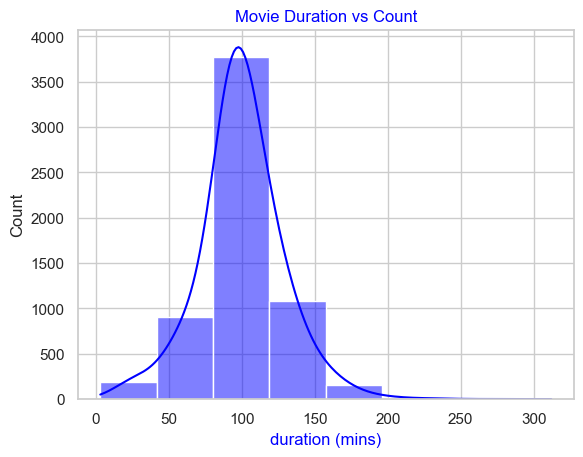

In [27]:
sns.set(style="whitegrid")
sns.histplot(data=movieduration,x='duration',weights='uniquecount',bins=8,kde=True,color='blue')
plt.title('Movie Duration vs Count',color='blue')
plt.xlabel('duration (mins)',color='blue')
plt.show()

In [28]:
tv_showduration=tv_show.groupby('duration')['title'].nunique().reset_index().sort_values('title',ascending=False)
tv_showduration.columns=['duration','uniquecount']
tv_showduration.reset_index(inplace=True)
tv_showduration.drop(columns=['index'],inplace=True)
tv_showduration.head()

,duration,uniquecount
0,1 Season,1793
1,2 Seasons,425
2,3 Seasons,199
3,4 Seasons,95
4,5 Seasons,65


## Extracting Duration of TV Shows

In [29]:
tv_showduration['duration'] = tv_showduration['duration'].str.extract('(\d+)', expand=False)
tv_showduration['duration'] = pd.to_numeric(tv_showduration['duration'])

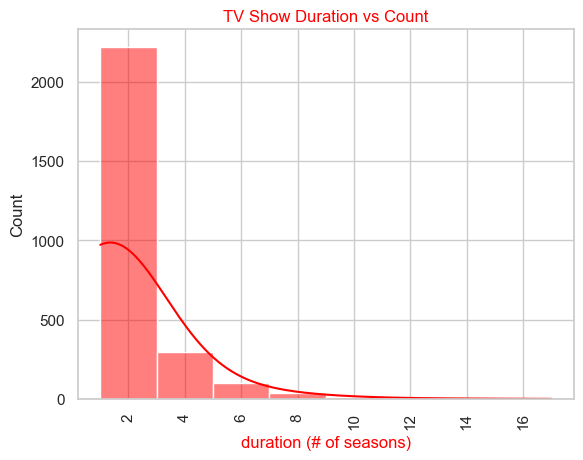

In [30]:
sns.set(style="whitegrid")
sns.histplot(data=tv_showduration,x='duration',weights='uniquecount',bins=8,kde=True,color='red')
plt.title('TV Show Duration vs Count',color='red')
plt.xlabel('duration (# of seasons)',color='red')
plt.xticks(rotation=90)
plt.show()

## Insights: Distribution of Movie Duration is unimodal and slightly right skewed with peak at 90 minutes and mean slightly higher than the median which is around 100 minutes.For TV Shows also it is unimodal right skewed with peak at 1 season,median around 2-3 seasons and mean slightly higher than that.

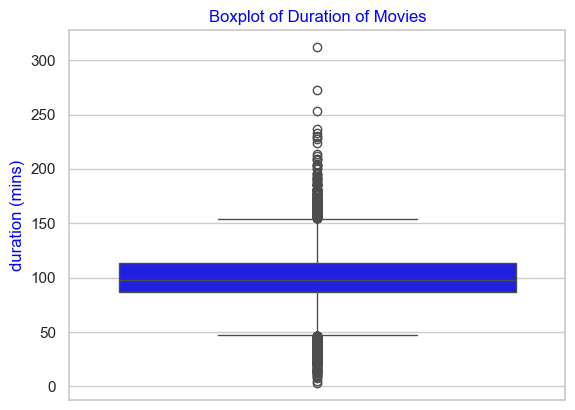

In [31]:
moviecopy=movie.copy(deep=False)
moviecopy['duration'] = moviecopy['duration'].str.extract('(\d+)', expand=False)
moviecopy['duration'] = pd.to_numeric(moviecopy['duration'])
movieboxduration=moviecopy.drop_duplicates(subset=['title','duration'])
sns.set(style="whitegrid")
sns.boxplot(data=movieboxduration,y='duration',color='blue')
plt.title('Boxplot of Duration of Movies',color='blue')
plt.ylabel('duration (mins)',color='blue')
plt.show()

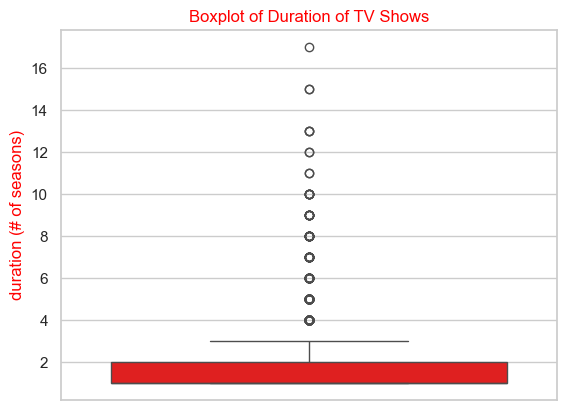

In [32]:
tv_show_copy=tv_show.copy(deep=False)
tv_show_copy['duration'] = tv_show_copy['duration'].str.extract('(\d+)', expand=False)
tv_show_copy['duration'] = pd.to_numeric(tv_show_copy['duration'])
tv_show_boxduration=tv_show_copy.drop_duplicates(subset=['title','duration'])
sns.set(style="whitegrid")
sns.boxplot(data=tv_show_boxduration,y='duration',color='red')
plt.title('Boxplot of Duration of TV Shows',color='red')
plt.ylabel('duration (# of seasons)',color='red')
plt.show()

## There are outliers for Movie duration in both ends whereas for TV Shows there are outliers only in the higher end.

## 2.a Number of Movies by country (Top 10)

In [33]:
movie=df[df['type']=='Movie']
group=movie.groupby('country',as_index=False)['title'].nunique()
group=group.sort_values('title',ascending=False)
group.columns=['country','uniquecount']
top10_movies=group.iloc[:10].reset_index().drop(columns='index')
top10_movies.head()

,country,uniquecount
0,United States,2752
1,India,962
2,United Kingdom,534
3,International,440
4,Canada,319


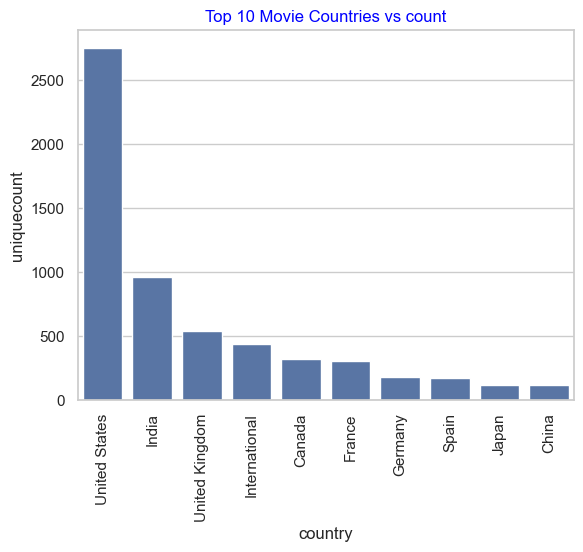

In [34]:
sns.set(style="whitegrid")
sns.barplot(data=top10_movies,x='country',y='uniquecount')
plt.title('Top 10 Movie Countries vs count',color='blue')
plt.xticks(rotation=90)
plt.show()

## 2.b Number of TV Shows by country (Top 10)

In [35]:
tv_show=df[df['type']=='TV Show']
group=tv_show.groupby('country',as_index=False)['title'].nunique()
group=group.sort_values('title',ascending=False)
group.columns=['country','uniquecount']
top10_tv_show=group.iloc[:10].reset_index().drop(columns='index')
top10_tv_show.head()

,country,uniquecount
0,United States,938
1,International,391
2,United Kingdom,272
3,Japan,199
4,South Korea,170


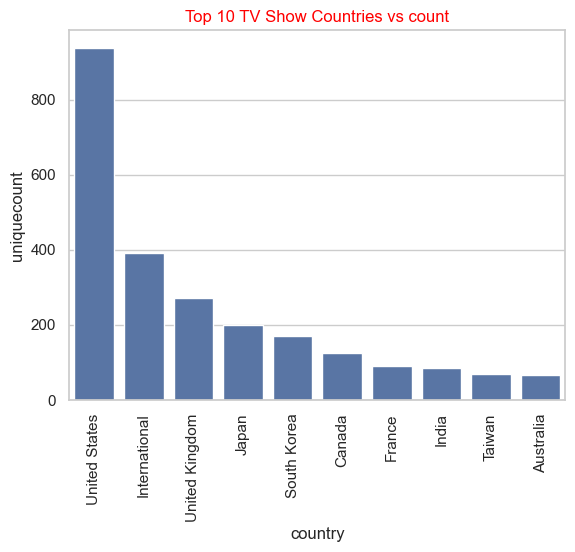

In [36]:
sns.set(style="whitegrid")
sns.barplot(data=top10_tv_show,x='country',y='uniquecount')
plt.title('Top 10 TV Show Countries vs count',color='red')
plt.xticks(rotation=90)
plt.show()

## Insights: USA leads in both Movie and TV Show count.

## 3.a Best week to release Movies and Tv Shows

## i)Best Movie Week

In [37]:
weekmovie=movie.groupby('week_added',as_index=False)['title'].nunique()
weekmovie.columns=['week','uniquecount']
weekmovie = weekmovie.sort_values('uniquecount', ascending=False).iloc[:10, :]
weekmovie.reset_index(inplace=True)
weekmovie.drop(columns=['index'],inplace=True)
weekmovie['week']=weekmovie['week'].astype(int)
weekmovie.head()

,week,uniquecount
0,1,316
1,44,243
2,40,215
3,9,207
4,26,195


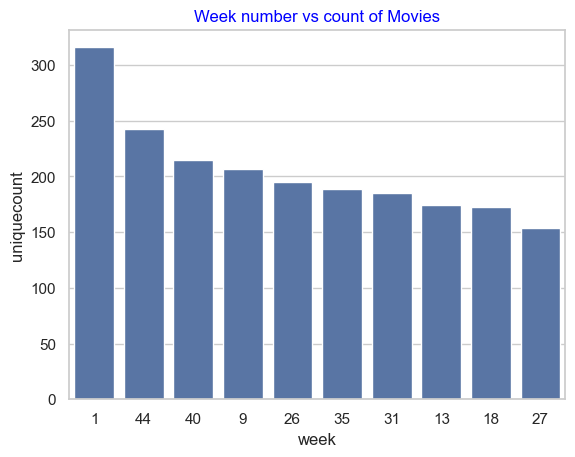

In [38]:
sns.set(style="whitegrid")
sns.barplot(data=weekmovie, x='week', y='uniquecount', order=weekmovie['week'].tolist())
plt.title('Week number vs count of Movies',color='blue')
plt.show()

## ii) Best TV Show week

In [39]:
weektv_show=tv_show.groupby('week_added',as_index=False)['title'].nunique()
weektv_show.columns=['week','uniquecount']
weektv_show = weektv_show.sort_values('uniquecount', ascending=False).iloc[:10, :]
weektv_show.reset_index(inplace=True)
weektv_show.drop(columns=['index'],inplace=True)
weektv_show.head()

,week,uniquecount
0,27,86
1,31,83
2,13,76
3,24,76
4,44,75


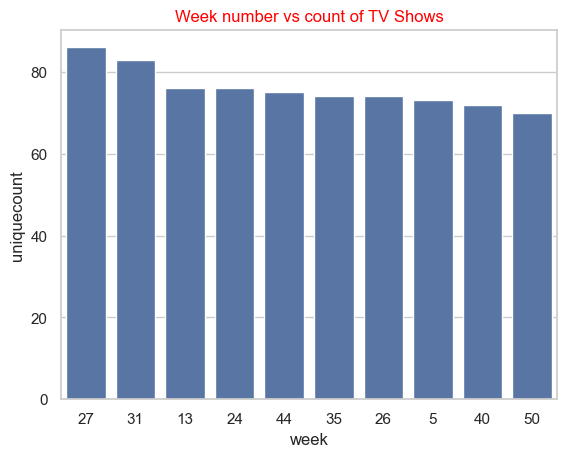

In [40]:
sns.set(style="whitegrid")
sns.barplot(data=weektv_show, x='week', y='uniquecount', order=weektv_show['week'].tolist())
plt.title('Week number vs count of TV Shows',color='red')
plt.show()

## Insights: Most Movies are added in week 1 and most TV Shows are added in week 27.

## 3.b Best month to release Movies and Tv Shows

## i)Best Movie Month

In [41]:
monthmovie=movie.groupby('month_added',as_index=False)['title'].nunique()
monthmovie.columns=['month','uniquecount']
monthmovie = monthmovie.sort_values('uniquecount', ascending=False).iloc[:10, :]
monthmovie.reset_index(inplace=True)
monthmovie.drop(columns=['index'],inplace=True)
monthmovie.head()

,month,uniquecount
0,7.0,565
1,4.0,550
2,12.0,547
3,1.0,546
4,10.0,545


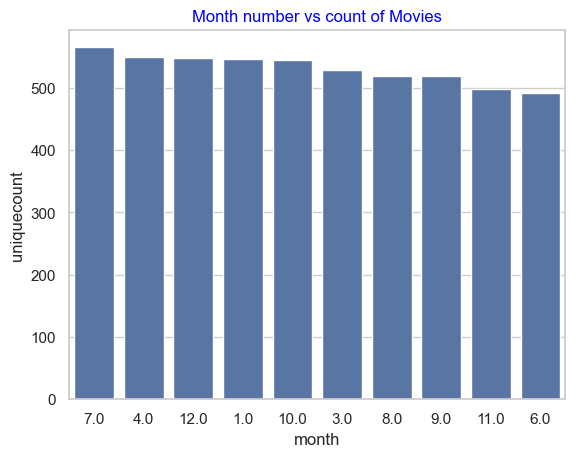

In [42]:
sns.set(style="whitegrid")
sns.barplot(data=monthmovie, x='month', y='uniquecount', order=monthmovie['month'].tolist())
plt.title('Month number vs count of Movies',color='blue')
plt.show()

## ii)Best TV Show Month

In [43]:
monthtv_show=tv_show.groupby('month_added',as_index=False)['title'].nunique()
monthtv_show.columns=['month','uniquecount']
monthtv_show = monthtv_show.sort_values('uniquecount', ascending=False).iloc[:10, :]
monthtv_show.reset_index(inplace=True)
monthtv_show.drop(columns=['index'],inplace=True)
monthtv_show.head()

,month,uniquecount
0,12.0,266
1,7.0,264
2,9.0,252
3,6.0,236
4,8.0,236


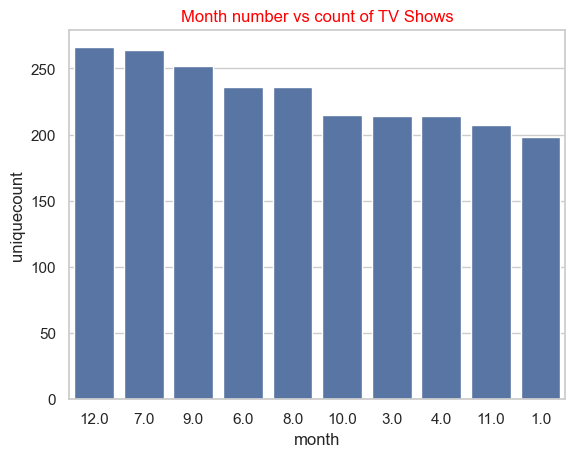

In [44]:
sns.set(style="whitegrid")
sns.barplot(data=monthtv_show, x='month', y='uniquecount', order=monthtv_show['month'].tolist())
plt.title('Month number vs count of TV Shows',color='red')
plt.show()

## Insights: Most Movies are added in July and most TV Shows are added in December.

## 4.a Top 10 cast  for Movies and TV Shows

## i)Top 10 cast for Movies

In [45]:
moviecast = movie.groupby('cast')['title'].nunique().sort_values(ascending=False).reset_index()
moviecast.columns=['cast','uniquecount']
moviecast.head()

,cast,uniquecount
0,Unknown Cast,475
1,Anupam Kher,42
2,Shah Rukh Khan,35
3,Naseeruddin Shah,32
4,Om Puri,30


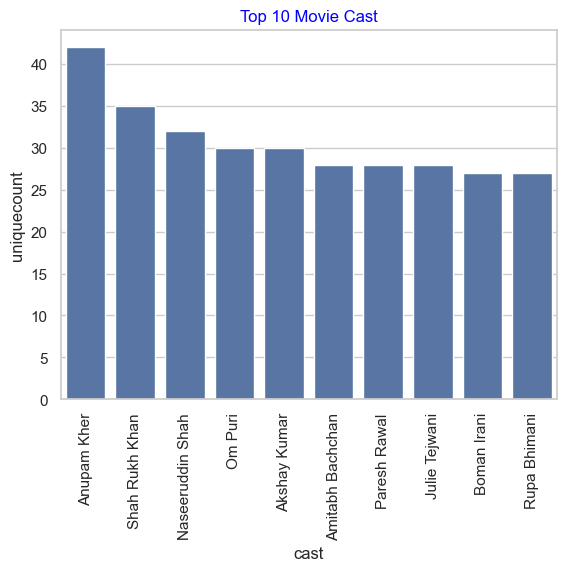

In [46]:
moviecast=moviecast[moviecast['cast']!='Unknown Cast'].iloc[:10]
sns.set(style="whitegrid")
sns.barplot(data=moviecast,x='cast',y='uniquecount')
plt.xticks(rotation=90)
plt.title('Top 10 Movie Cast',color='blue')
plt.show()

## ii)Top 10 cast for TV Shows

In [47]:
tv_showcast = tv_show.groupby('cast')['title'].nunique().sort_values(ascending=False).reset_index()
tv_showcast.columns=['cast','uniquecount']
tv_showcast.head()

,cast,uniquecount
0,Unknown Cast,350
1,Takahiro Sakurai,25
2,Yuki Kaji,19
3,Daisuke Ono,17
4,Ai Kayano,17


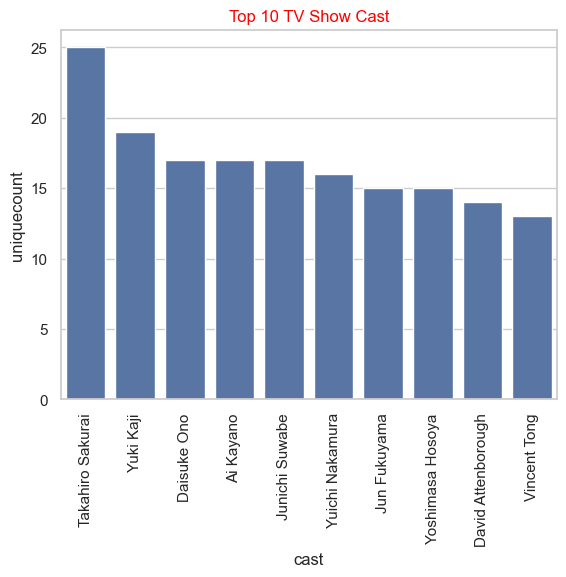

In [48]:
tv_showcast=tv_showcast[tv_showcast['cast']!='Unknown Cast'].iloc[:10]
sns.set(style="whitegrid")
sns.barplot(data=tv_showcast,x='cast',y='uniquecount')
plt.xticks(rotation=90)
plt.title('Top 10 TV Show Cast',color='red')
plt.show()

## 4.b Top 10 directors for Movies and TV Shows

## i)Top 10 directors for Movies

In [49]:
moviedirector = movie.groupby('director')['title'].nunique().sort_values(ascending=False).reset_index()
moviedirector.columns=['director','uniquecount']
moviedirector.head()

,director,uniquecount
0,Unknown Director,188
1,Rajiv Chilaka,22
2,Jan Suter,21
3,Raúl Campos,19
4,Suhas Kadav,16


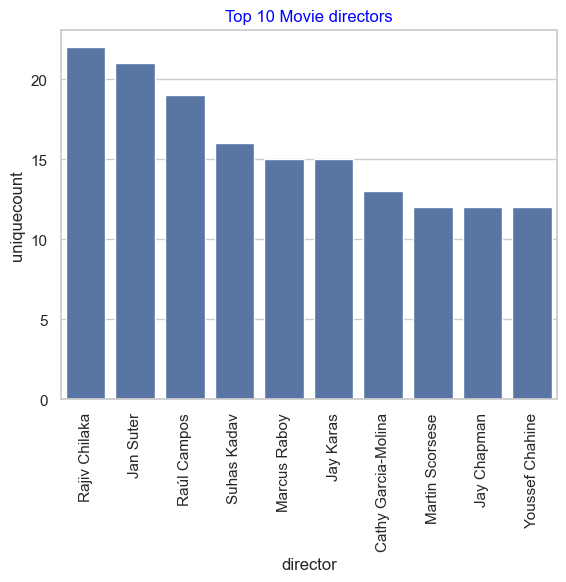

In [50]:
moviedirector=moviedirector[moviedirector['director']!='Unknown Director'].iloc[:10]
sns.set(style="whitegrid")
sns.barplot(data=moviedirector,x='director',y='uniquecount')
plt.xticks(rotation=90)
plt.title('Top 10 Movie directors',color='blue')
plt.show()

## ii)Top 10 directors for TV Shows

In [51]:
tv_showdirector = tv_show.groupby('director')['title'].nunique().sort_values(ascending=False).reset_index()
tv_showdirector.columns=['director','uniquecount']
tv_showdirector.head()

,director,uniquecount
0,Unknown Director,2446
1,Ken Burns,3
2,Alastair Fothergill,3
3,Stan Lathan,2
4,Joe Berlinger,2


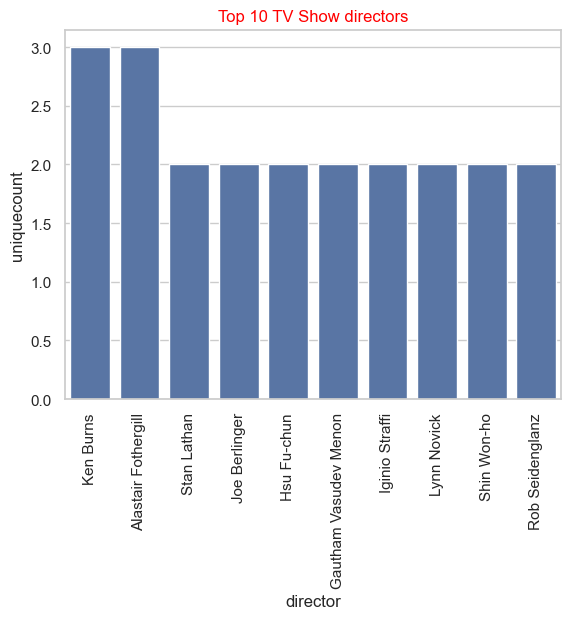

In [52]:
tv_showdirector=tv_showdirector[tv_showdirector['director']!='Unknown Director'].iloc[:10]
sns.set(style="whitegrid")
sns.barplot(data=tv_showdirector,x='director',y='uniquecount')
plt.xticks(rotation=90)
plt.title('Top 10 TV Show directors',color='red')
plt.show()

## 5. Which genre movies are more popular or produced more?

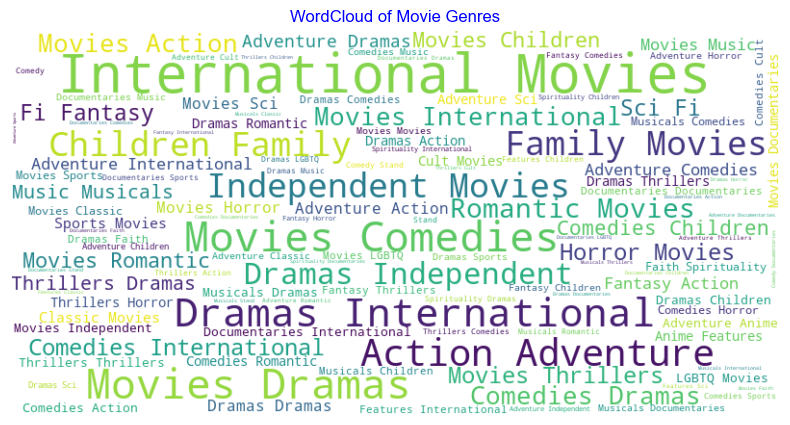

In [53]:
all_genres = ' '.join(movie['listed_in'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud of Movie Genres',color='blue')
plt.axis('off')
plt.show()

## Insights: We can conclude that International Movies,Dramas and Comedies are the most produced genres of movies.

## 6. After how many days the movie will be added to Netflix after the release of the movie?

In [54]:
moviereset=movie.reset_index()
moviediff=moviereset[['show_id','datediff_day']]
moviediff=moviediff.groupby('show_id',as_index=False)['datediff_day'].mean()
predict=moviediff['datediff_day'].value_counts().reset_index().iloc[:20]
median=round((predict.iloc[9,0]+predict.iloc[10,0])/2,2)
mean=predict.iloc[:,0].mean()
print('Median is '+str(median)+' days Mean is '+str(mean)+' days')
predict.head()

Median is 274.5 days Mean is 277.45 days


,datediff_day,count
0,304.0,34
1,153.0,34
2,365.0,32
3,243.0,31
4,396.0,28


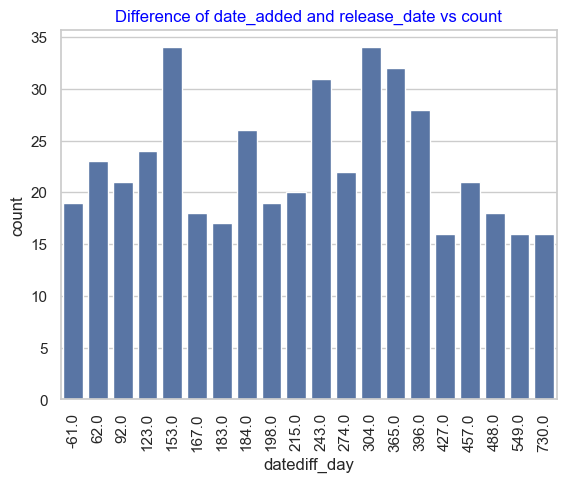

In [55]:
sns.set(style="whitegrid")
sns.barplot(data=predict, x='datediff_day', y='count')
plt.title('Difference of date_added and release_date vs count',color='blue')
plt.xticks(rotation=90)
plt.show()

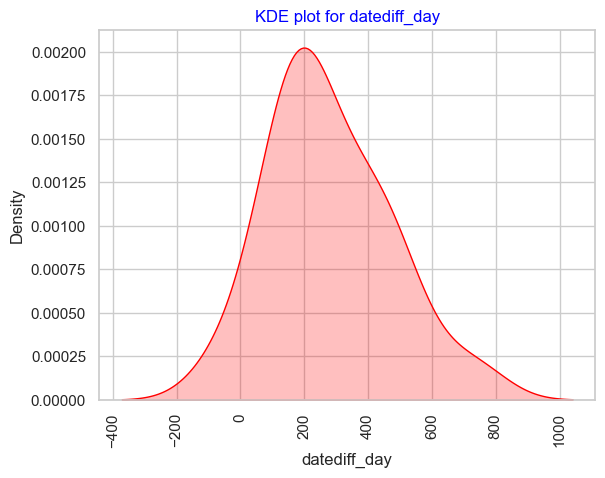

In [56]:
sns.set(style="whitegrid")
sns.kdeplot(data=predict, x='datediff_day', color='red', fill=True)
plt.title('KDE plot for datediff_day',color='blue')
plt.xticks(rotation=90)
plt.show()

## Insights: Distribution is bimodal with peaks at 153 days and 304 days and the mean and median are both close to 280 days which is about 10 months for the top 20 most frequent datediff_day s.We can predict that within 10 months of the movie release it will be added to Netflix.

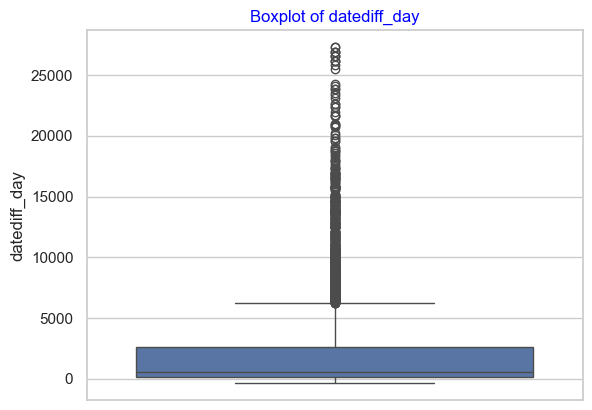

In [57]:
boxpredict=movie.drop_duplicates(subset=['title','datediff_day'])
sns.set(style="whitegrid")
sns.boxplot(data=boxpredict,y='datediff_day')
plt.title('Boxplot of datediff_day',color='blue')
plt.show()

## There are a lot of outliers for movie releases in the higher end which shows that the difference between release_date and movie_added date depends a lot on the demand and popularity of the movies.

## 7. Is Duration of Movies or TV Shows getting shorter with time?

In [58]:
moviecopy = movie.copy(deep=False)
moviecopy['duration'] = moviecopy['duration'].str.extract('(\d+)', expand=False)
moviecopy['duration'] = pd.to_numeric(moviecopy['duration'])

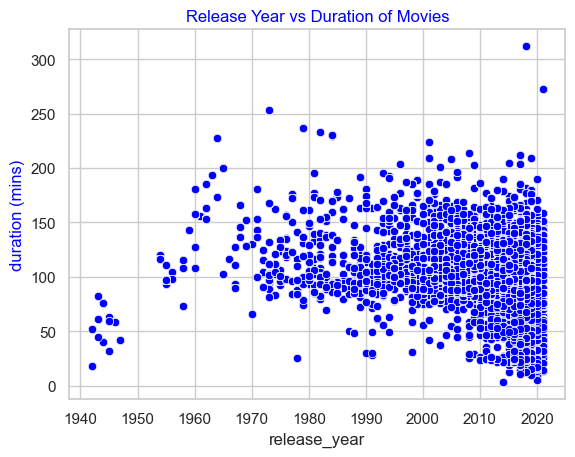

In [59]:
sns.set(style="whitegrid")
sns.scatterplot(data=moviecopy,x='release_year',y='duration',color='blue')
plt.title('Release Year vs Duration of Movies',color='blue')
plt.ylabel('duration (mins)',color='blue')
plt.show()

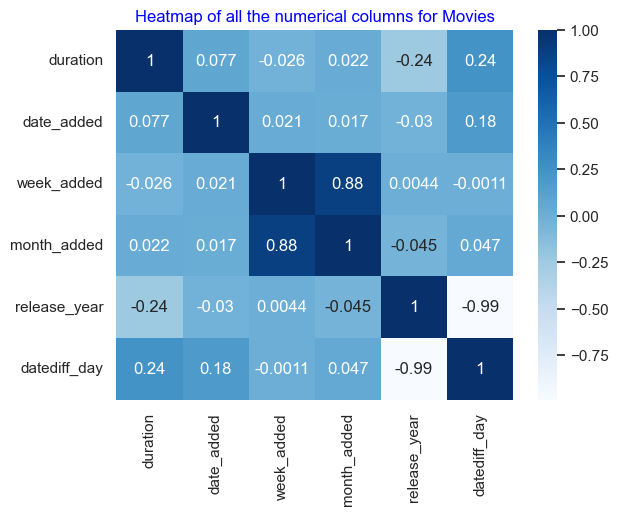

In [60]:
moviecopy=moviecopy[['duration','date_added','week_added','month_added','release_year','datediff_day']]
movie_corr=moviecopy.corr()
sns.heatmap(movie_corr,cmap='Blues',annot=True)
plt.title('Heatmap of all the numerical columns for Movies',color='blue')
plt.show()

In [61]:
tv_show_copy=tv_show.copy(deep=False)
tv_show_copy['duration'] = tv_show_copy['duration'].str.extract('(\d+)', expand=False)
tv_show_copy['duration'] = pd.to_numeric(tv_show_copy['duration'])

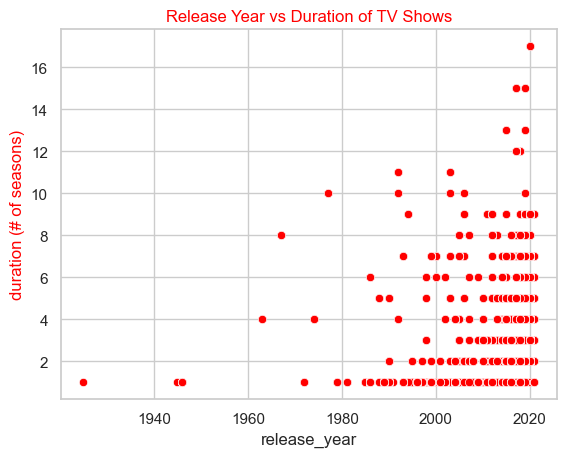

In [62]:
sns.set(style="whitegrid")
sns.scatterplot(data=tv_show_copy,x='release_year',y='duration',color='red')
plt.ylabel('duration (# of seasons)',color='red')
plt.title('Release Year vs Duration of TV Shows',color='red')
plt.show()

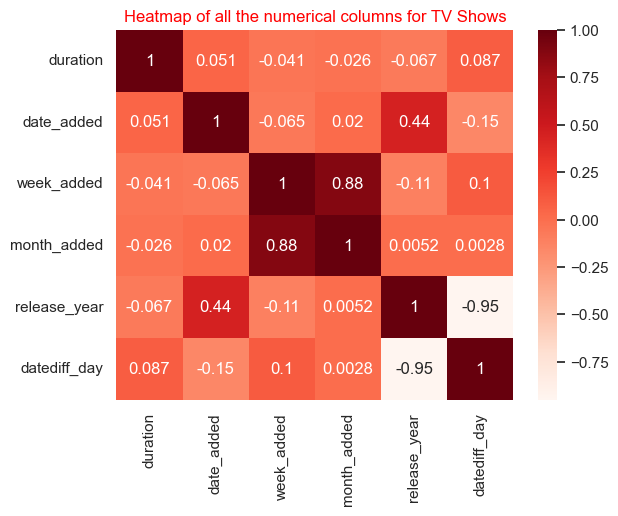

In [63]:
tv_show_copy=tv_show_copy[['duration','date_added','week_added','month_added','release_year','datediff_day']]
tv_show_corr=tv_show_copy.corr()
sns.heatmap(tv_show_corr,cmap='Reds',annot=True)
plt.title('Heatmap of all the numerical columns for TV Shows',color='red')
plt.show()

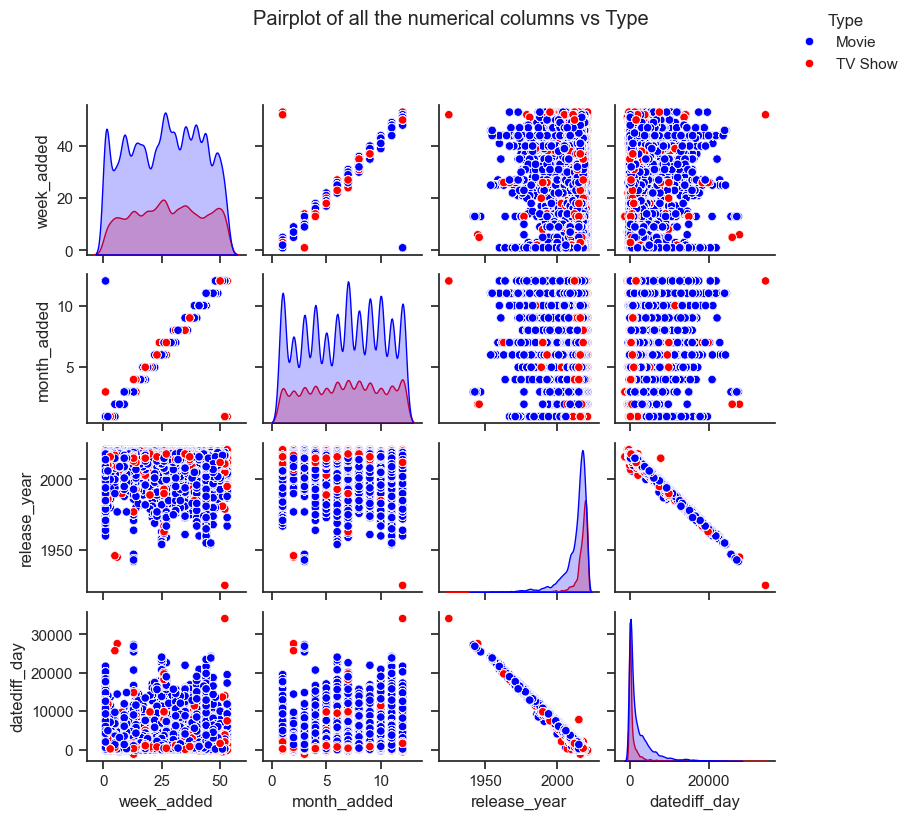

In [64]:
dfcopy=df[['duration','date_added','week_added','month_added','release_year','datediff_day','type']]
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(dfcopy,hue='type', height=2,palette={'Movie':'blue','TV Show':'red'})
sns.move_legend(g,title='Type',loc='upper right')
plt.suptitle("Pairplot of all the numerical columns vs Type", y=1.02) 
plt.subplots_adjust(top=0.9)
plt.show()

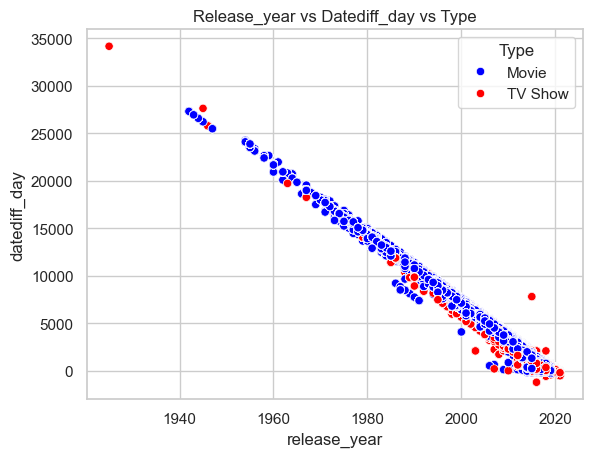

In [65]:
sns.set(style="whitegrid")
sns.scatterplot(data=df,x='release_year',y='datediff_day',hue='type',palette={'Movie':'blue','TV Show':'red'})
plt.title('Release_year vs Datediff_day vs Type')
plt.legend(title='Type')
plt.show()

## Insights: We cannot conclude that Movies or TV Shows duration and release_year are strongly correlated. No the Movies or TV Show s are not getting shorter.We can only conclude that datediff_day is decreasing with increase in release_year for both Movies and TV Shows so shows are added faster after release with passing of time.

## 8. Is the number of movies released per year increasing with time?

In [66]:
moviecopy = movie.copy(deep=False).reset_index()
moviecopy=moviecopy.drop_duplicates(subset=['show_id','release_year'])
last35movie=moviecopy.groupby('release_year',as_index=False)['title'].count().iloc[-35:].reset_index()
last35movie.drop(columns='index',inplace=True)
last35movie.columns=['release_year','moviecount']
last35movie.head()

,release_year,moviecount
0,1987,8
1,1988,16
2,1989,15
3,1990,19
4,1991,16


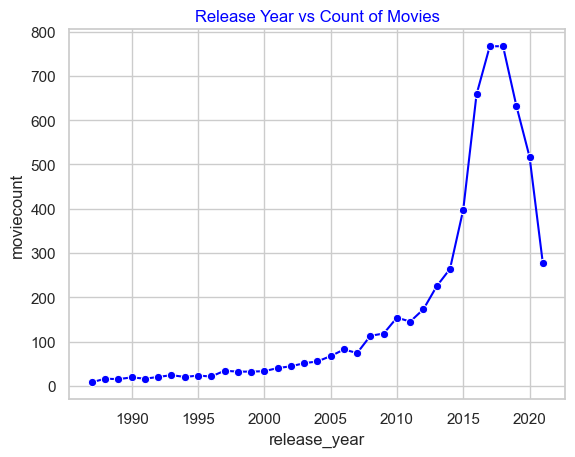

In [67]:
sns.set(style="whitegrid")
sns.lineplot(data=last35movie,x='release_year',y='moviecount',color='blue',marker='o')
plt.title('Release Year vs Count of Movies',color='blue')
plt.show()

## Insights: In last 35 years number of movies released each year has increased before peaking in 2019-2020 and after then there is a drop.

## 9. Is Netflix focusing more on TV Shows recently ?

## Added 'date_added_year' by extracting year from 'date_added' column

In [68]:
dfcopy=df.copy(deep=False).reset_index()
dfcopy['date_added_year']=dfcopy['date_added'].dt.year
dfcopy.drop_duplicates(subset=['show_id','date_added','type'],inplace=True)
dfcopy=dfcopy.groupby(['type','date_added_year'],as_index=False)['show_id'].count()
dfcopy.rename(columns={'show_id':'count'},inplace=True)
dfcopy.sort_values('count',ascending=False).reset_index().drop(columns='index',inplace=True)
dfcopy.head()

,type,date_added_year,count
0,Movie,2008,1
1,Movie,2009,2
2,Movie,2010,1
3,Movie,2011,13
4,Movie,2012,3


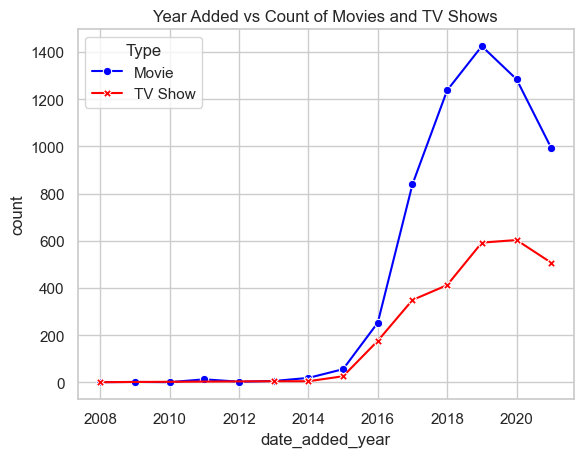

In [71]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The figure layout has changed to tight")
sns.set(style="whitegrid")
sns.lineplot(data=dfcopy,x='date_added_year',y='count',style='type',hue='type',
            markers=True,dashes=False,palette={'Movie': 'blue', 'TV Show': 'red'})
plt.legend(title='Type',loc='upper left')
plt.title('Year Added vs Count of Movies and TV Shows')
plt.show()

## Insights: The number of movies and TV Shows added per year is both similar increasing curves from 2015 to 2019 and then decreasing.Between movies and TV shows more number of movies are added each year so Netflix is not focusing more on TV Shows recently.

## 10. What content is available in what countries?

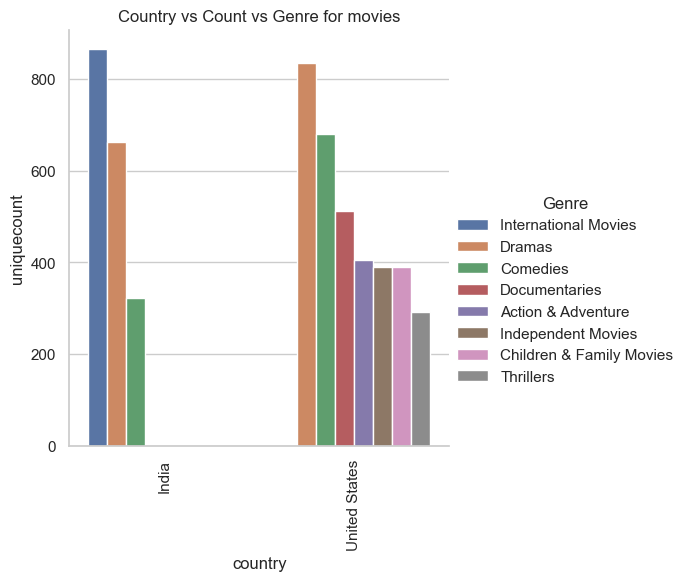

In [74]:
group = movie.groupby(['country', 'listed_in'], as_index=False)['title'].nunique().sort_values('title', ascending=False).reset_index().iloc[:, 1:]
group = group.rename(columns={'listed_in': 'genre','title':'uniquecount'}).iloc[:10]
sns.set(style="whitegrid")
g=sns.catplot(kind='bar',data=group,x='country',y='uniquecount',hue='genre')
sns.move_legend(g,title='Genre',loc='center right')
plt.title('Country vs Count vs Genre for movies')
plt.xticks(rotation=90)
plt.show()

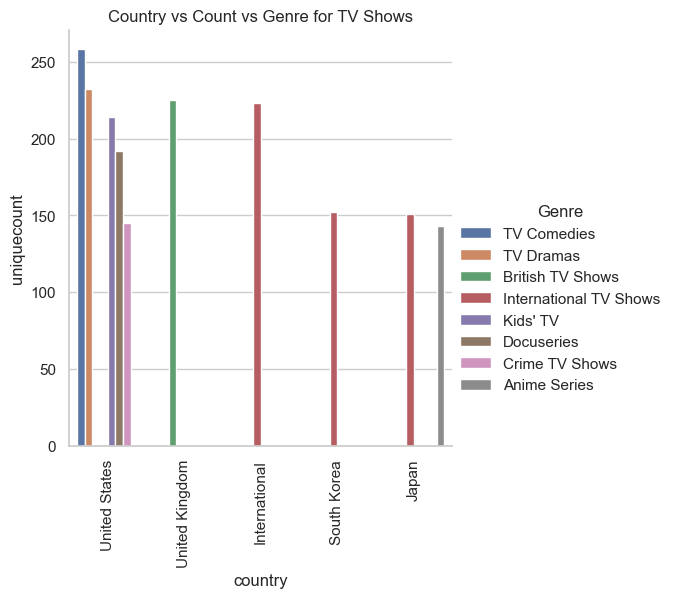

In [75]:
group = tv_show.groupby(['country', 'listed_in'], as_index=False)['title'].nunique().sort_values('title', ascending=False).reset_index().iloc[:, 1:]
group = group.rename(columns={'listed_in': 'genre','title':'uniquecount'}).iloc[:10]
sns.set(style="whitegrid")
g=sns.catplot(kind='bar',data=group,x='country',y='uniquecount',hue='genre')
sns.move_legend(g,title='Genre',loc='center right')
plt.title('Country vs Count vs Genre for TV Shows')
plt.xticks(rotation=90)
plt.show()

## Insights: International movies and dramas are popular available movie genres available in India whereas Dramas and Comedies are more popular movie genres  in USA. As for TV Shows in USA TV Comedies and TV Dramas are available,in UK,British TV Shows are available.International TV shows are available in South Korea,Japan and internationally.Need additional stream or viewership data to make suggestions about making shows available in certain country.

# 11. Recommendations

## Insights:

1. **Duration Distribution:**
    - Distribution of Movie Duration is unimodal and slightly right-skewed, with a peak at 90 minutes.
    - TV Shows have a peak around 1 season, with a median of 2-3 seasons.
    
2. **Geographical Trends:**
    - USA leads in both Movie and TV Show count.

3. **Release Timing:**
    - Most Movies are added in week 1, and most TV Shows are added in week 27.
    - July is the peak month for adding Movies whereas for TV Shows it is December.

4. **Genre Production:**
    - Most produced genres for Movies are International Movies, Dramas, and Comedies.
    - For TV Shows, it's International TV Shows and TV Dramas.

5. **Datediff Distribution:**
    - Datediff distribution is bimodal, with peaks at 153 days and 304 days.
    - Predictions suggest movies will be added within 10 months of release.

6. **Outliers:**
    - Outliers observed in Movie duration and datediff, indicating demand-driven variations.

7. **Duration Trends:**
    - No strong correlation between Movie/TV Show duration and release_year.
    - Movies and TV Shows are not getting consistently shorter.

8. **Temporal Trends:**
    - In the last 35 years, the number of movies released per year increased before saturating in 2019-2020, followed by a decline.
    - Similar trends observed in the number of movies and TV Shows added vs year which is increasing from 2015-2019 then dropping.
    - Between movies and TV Shows more movies are added each year.

## Recommendations:

1. **Content Duration Strategy:**
    - Recognize the diversity in Movie and TV Show durations, and tailor content length based on genre and audience expectations.
    - Movies of duration close to 2 hrs and TV Shows with 1-4 seasons suggested.
    
2. **Geographic Focus:**
    - Given USA's dominance, consider tailoring content or marketing strategies for the American audience.
    - Could introduce region specific discounts to increase viewerships.

3. **Optimal Release Timing:**
    - For Movies, consider releasing in Week 1 and July, to potentially maximize viewership.
    - For TV shows, Week 27 and December seem to be popular, aligning releases with these times may attract more audience.

4. **Best Cast and Director:**
    - For future projects include casts from the top 10 cast members for both Movie and TV Shows.
    - For future projects include directors from the top 10 directors for both Movie and TV Shows.

5. **Targeting Genres:**
    - Focus on producing more International Movies, Dramas, and Comedies, as these genres have shown popularity.
    - For TV Shows, prioritize International TV Shows and TV Dramas.

6. **Datediff Strategy:**
    - Plan content releases with an understanding of the bimodal datediff distribution.
    - Strategic planning and adding within 10 months of movie release might align with viewership patterns.
    
7. **Outlier Considerations:**
    - Analyze outliers in duration and datediff_day for potential insights into audience preferences and trends.
    - For example long or short length movies might have specific audience.
    - Add date of movies and TV Shows could be decided based on demand or popularity.

8. **Adaptation to Temporal Trends:**
    - Consider the temporal trends in the number of releases when planning content production schedules.
    - Find out why after 2019-2020 there is a decline in number of movies released as well as number of movies added and solve the problem.
    - As there is a higher number of movies added each year compared to TV shows, consider a balanced approach or 
      strategically allocate resources based on the observed trend.